In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
%matplotlib inline
pd.set_option('display.max_rows', 1000)
sns.set()

# Price data

In [2]:
# Read data
data = pd.read_excel("D:/Dropbox/Dropbox/Tandon_Spring_2020/AlgoHighFrequencyTrading/Assignment2_OrderSet/SecondPriceSet.xlsx", index_col=0)
data['Mid'] = 0.5 * (data['Bid'] + data['Ask'])
data['BOSpread'] = data['Ask'] - data['Bid']
data.head()

,Bid,Ask,Mid,BOSpread
2018-01-07 22:02:04,1.35554,1.35618,1.355860,0.00064
2018-01-07 22:02:05,1.35554,1.35619,1.355865,0.00065
2018-01-07 22:02:06,1.35554,1.35619,1.355865,0.00065
2018-01-07 22:02:07,1.35546,1.35619,1.355825,0.00073
2018-01-07 22:02:08,1.35546,1.35619,1.355825,0.00073


# OrderSet data

In [254]:
# Read data
order = pd.read_csv("D:/Dropbox/Dropbox/Tandon_Spring_2020/AlgoHighFrequencyTrading/Assignment2_OrderSet/OrderSet.csv", 
                    parse_dates=['Time'])
order.head()

,Side,Time
0,B,2018-01-07 22:04:12
1,S,2018-01-07 22:04:13
2,B,2018-01-07 22:04:14
3,S,2018-01-07 22:04:15
4,B,2018-01-07 22:04:16


### Merge OrderSet with Price data

In [255]:
order = order.merge(data, left_on=['Time'], right_index=True, how = 'inner')
Order = order.copy()
order.head()

,Side,Time,Bid,Ask,Mid,BOSpread
0,B,2018-01-07 22:04:12,1.35558,1.35615,1.355865,0.00057
1,S,2018-01-07 22:04:13,1.35558,1.35615,1.355865,0.00057
2,B,2018-01-07 22:04:14,1.35558,1.35615,1.355865,0.00057
3,S,2018-01-07 22:04:15,1.35558,1.35615,1.355865,0.00057
4,B,2018-01-07 22:04:16,1.35558,1.35615,1.355865,0.00057


# Method1 : Market Taking (MT)
For each order, we will aggress the market immediately and therefore incur the (half) Bid/Offer spread. So each time we trade we lose half of the spread.


In [256]:
order['MT_Pnl'] = -0.5 * order['BOSpread']
order.head()

,Side,Time,Bid,Ask,Mid,BOSpread,MT_Pnl
0,B,2018-01-07 22:04:12,1.35558,1.35615,1.355865,0.00057,-0.000285
1,S,2018-01-07 22:04:13,1.35558,1.35615,1.355865,0.00057,-0.000285
2,B,2018-01-07 22:04:14,1.35558,1.35615,1.355865,0.00057,-0.000285
3,S,2018-01-07 22:04:15,1.35558,1.35615,1.355865,0.00057,-0.000285
4,B,2018-01-07 22:04:16,1.35558,1.35615,1.355865,0.00057,-0.000285


# Method2 : Opportunistic Market Making (OMM)

For each order, we will rest it within the Bid/Offer spread, for a given amount of time, awaiting for its (possible) opportunistic execution.


#### Here we may define (and choose a value) for a max Stop Loss (SL) in case the market runs away from us. If it is the case, we will then aggress the market to fill your order. Here we use -3bps.
#### Again, in both cases, we will also define (and choose a value) for a max Time to Execution (TTE). Upon reaching this time limit, we will aggress the market to fill your order. Here we set 15s.


In [202]:
# Set up SL and TTE
StopLoss = -0.0003
TimeToExecution = timedelta(seconds=15).total_seconds()
TimeToExecution

15.0

## Method 2.1 : OMMSide
Joining “our side” of the market (i.e. the Bid price if you are buying, the Offer if selling)

In [257]:
def OMMSide(SL,TTE):
    #Initialize
    OMMSide_Pnl = []       # execute pnl list
    OMMSide_TE = []        # Time to Execution
    OMMSide_Execution = [] # Execution type - TTE,SL,or Success
    for i in range(len(order)):
        data_new = data[data.index > order.loc[i,'Time']]
        data_new = data_new.reset_index()
        Mid = order.loc[i,'Mid']
        if order.loc[i,'Side'] == 'B':
            side_price = order.loc[i,'Bid']
            stop_loss_line = order.loc[i,'Ask'] - SL
            # wait in mkt
            wait = 0
            while side_price < data_new.loc[wait,'Ask'] and data_new.loc[wait, 'Ask'] < stop_loss_line and wait < TTE - 1:
                wait = wait + 1
            if side_price >= data_new.loc[wait,'Ask']:
                execute_price = side_price
            else:
                execute_price = data_new.loc[wait, 'Ask'] #aggress the mkt
            # compute pnl
            OMMSide_Pnl.append(Mid - execute_price)
            OMMSide_TE.append(wait + 1)
            if execute_price >= stop_loss_line :
                OMMSide_Execution.append('SL')
            elif wait == TTE - 1:
                OMMSide_Execution.append('TTE')
            else:
                OMMSide_Execution.append('Success')
                
        else : #Side =='S'
            side_price = order.loc[i, 'Ask']
            stop_loss_line = order.loc[i,'Bid'] + SL
            wait = 0
            while side_price > data_new.loc[wait, 'Bid'] and data_new.loc[wait, 'Bid'] > stop_loss_line and wait < TTE - 1:
                wait = wait + 1
            if side_price <= data_new.loc[wait,'Bid']:
                execute_price = side_price
            else:
                execute_price = data_new.loc[wait, 'Bid'] #aggress the mkt
            # pnl
            OMMSide_Pnl.append(execute_price - Mid)
            OMMSide_TE.append(wait + 1)
            if execute_price <= stop_loss_line :
                OMMSide_Execution.append('SL')
            elif wait == TTE - 1:
                OMMSide_Execution.append('TTE')
            else :
                OMMSide_Execution.append('Success')
    # Edit in orderSet directly            
    order['OMMSide_Pnl'] = OMMSide_Pnl
    order['OMMSide_TE'] = OMMSide_TE
    order['OMMSide_Execution'] = OMMSide_Execution
    return np.median(OMMSide_Pnl)

In [258]:
OMMSide(StopLoss,TimeToExecution)
order

,Side,Time,Bid,Ask,Mid,BOSpread,MT_Pnl,OMMSide_Pnl,OMMSide_TE,OMMSide_Execution
0,B,2018-01-07 22:04:12,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE
1,S,2018-01-07 22:04:13,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE
2,B,2018-01-07 22:04:14,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE
3,S,2018-01-07 22:04:15,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE
4,B,2018-01-07 22:04:16,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE
5,B,2018-01-07 22:04:17,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE
6,B,2018-01-07 22:04:18,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE
7,S,2018-01-07 22:04:19,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE
8,S,2018-01-07 22:04:20,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE
9,S,2018-01-07 22:04:21,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE


## Method 2.2 : OMMMid
Resting our order at mid-market.

In [259]:
def OMMMid(SL,TTE):
    #Initialize
    OMMMid_Pnl = []       # execute pnl list
    OMMMid_TE = []        # Time to Execution
    OMMMid_Execution = [] # Execution type - TTE,SL,or Success
    for i in range(len(order)):
        data_new = data[data.index > order.loc[i,'Time']]
        data_new = data_new.reset_index()
        Mid = order.loc[i,'Mid']
        if order.loc[i,'Side'] == 'B':
            stop_loss_line = order.loc[i,'Ask'] - SL
            # wait in mkt
            wait = 0
            while Mid < data_new.loc[wait,'Ask'] and data_new.loc[wait, 'Ask'] < stop_loss_line and wait < TTE - 1:
                wait = wait + 1
            if Mid >= data_new.loc[wait,'Ask']:
                execute_price = Mid
            else:
                execute_price = data_new.loc[wait, 'Ask'] #aggress the mkt
            # compute pnl
            OMMMid_Pnl.append(Mid - execute_price)
            OMMMid_TE.append(wait + 1)
            if execute_price >= stop_loss_line :
                OMMMid_Execution.append('SL')
            elif wait == TTE - 1:
                OMMMid_Execution.append('TTE')
            else:
                OMMMid_Execution.append('Success')
                
        else : #Side =='S'
            stop_loss_line = order.loc[i, 'Bid'] + SL
            wait = 0
            while Mid > data_new.loc[wait, 'Bid'] and data_new.loc[wait, 'Bid'] > stop_loss_line and wait < TTE - 1:
                wait = wait + 1
            if Mid <= data_new.loc[wait,'Bid']:
                execute_price = Mid
            else:
                execute_price = data_new.loc[wait, 'Bid'] #aggress the mkt
            # pnl
            OMMMid_Pnl.append(execute_price - Mid)
            OMMMid_TE.append(wait + 1)
            if execute_price <= stop_loss_line :
                OMMMid_Execution.append('SL')
            elif wait == TTE - 1:
                OMMMid_Execution.append('TTE')
            else :
                OMMMid_Execution.append('Success')
    # Edit in orderSet directly            
    order['OMMMid_Pnl'] = OMMMid_Pnl
    order['OMMMid_TE'] = OMMMid_TE
    order['OMMMid_Execution'] = OMMMid_Execution
    return np.median(OMMMid_Pnl)


In [260]:
OMMMid(StopLoss,TimeToExecution)
order

,Side,Time,Bid,Ask,Mid,BOSpread,MT_Pnl,OMMSide_Pnl,OMMSide_TE,OMMSide_Execution,OMMMid_Pnl,OMMMid_TE,OMMMid_Execution
0,B,2018-01-07 22:04:12,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
1,S,2018-01-07 22:04:13,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
2,B,2018-01-07 22:04:14,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
3,S,2018-01-07 22:04:15,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
4,B,2018-01-07 22:04:16,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
5,B,2018-01-07 22:04:17,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
6,B,2018-01-07 22:04:18,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
7,S,2018-01-07 22:04:19,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
8,S,2018-01-07 22:04:20,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
9,S,2018-01-07 22:04:21,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE


# Analysis:
### 1. PnL  Analysis

In [261]:
# Calculate min, max, mean, median and std for Pnls of MT, OMMSide, OMMMid.
MT_min, MT_max, MT_mean, MT_median, MT_std = order['MT_Pnl'].min(),order['MT_Pnl'].max(), order['MT_Pnl'].mean(), order['MT_Pnl'].median(), order['MT_Pnl'].std()
OMMSide_min, OMMSide_max, OMMSide_mean, OMMSide_median, OMMSide_std = order['OMMSide_Pnl'].min(),order['OMMSide_Pnl'].max(), order['OMMSide_Pnl'].mean(), order['OMMSide_Pnl'].median(), order['OMMSide_Pnl'].std()
OMMMid_min, OMMMid_max, OMMMid_mean, OMMMid_median, OMMMid_std = order['OMMMid_Pnl'].min(),order['OMMMid_Pnl'].max(), order['OMMMid_Pnl'].mean(), order['OMMMid_Pnl'].median(), order['OMMMid_Pnl'].std()

# store them in dataframe,count in bps
Pnl = {'MT':[MT_min, MT_max, MT_mean, MT_median, MT_std], 'OMMSide':[OMMSide_min, OMMSide_max, OMMSide_mean, OMMSide_median, OMMSide_std], 'OMMMid':[OMMMid_min, OMMMid_max, OMMMid_mean, OMMMid_median, OMMMid_std]}
Pnl = pd.DataFrame(data = Pnl, index = ['Pnl_min(bp)', 'Pnl_max(bp)', 'Pnl_mean(bp)', 'Pnl_median(bp)', 'Pnl_std(bp)']).T
Pnl = (Pnl*10000).round(3)
Pnl

,Pnl_min(bp),Pnl_max(bp),Pnl_mean(bp),Pnl_median(bp),Pnl_std(bp)
MT,-2.85,-0.0,-0.667,-0.200,1.023
OMMSide,-4.30,0.5,-1.196,-0.925,1.520
OMMMid,-4.30,0.0,-1.243,-0.125,1.437


Text(0.5, 1.0, 'Pnl Analysis, count in bps')

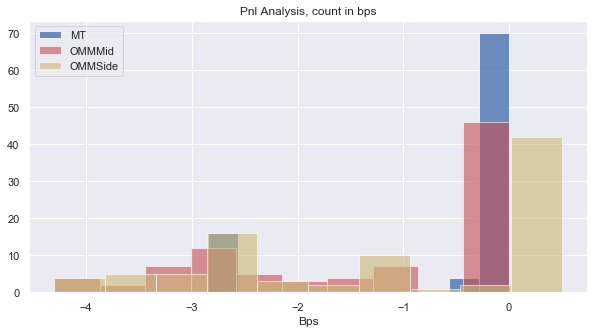

In [262]:
pnl_fig = plt.figure(figsize=[10,5])
ax = pnl_fig.add_subplot(111)
(order['MT_Pnl']*10000).hist(alpha=0.8, color='b', ax=ax, label='MT')
(order['OMMMid_Pnl']*10000).hist(alpha=0.6, color='r', ax=ax, label='OMMMid')
(order['OMMSide_Pnl']*10000).hist(alpha=0.6, color='y', ax=ax, label='OMMSide')
ax.legend()
plt.xlabel("Bps")
plt.title('Pnl Analysis, count in bps')

We may see from the graph and  the Pnl table:
- min : MT > OMMSide = OMMMid
- max : OMMSide > MT = OMMMid
- mean :  MT > OMMSide > OMMMid
- median: OMMMid > MT > OMMSide
- std: OMMSide > OMMMid > MT  


1. MT has the highest Pnl_mean, meaning that OMM doesn't always save our money, compared with direct MT.
2. MT has a higher Pnl_min since it doesn't need to wait, and never trigger TTE and SL.
3. OMMSide has the positive max, it is the only method that we could make a postive execution Pnl.
4. And OMMSide also gets the higher std, followed by OMMMid and MT, which means the more we wanna save cost when placing an order, the more risk we take.

### 2. TTE (Time to Execution, Duration) Analysis


In [376]:
# Calculate mean and median TTE for OMM. and MT execute immediately, so not shown.
SideTTE_mean, SideTTE_median = order['OMMSide_TE'].mean(), order['OMMSide_TE'].median()
MidTTE_mean, MidTTE_median = order['OMMMid_TE'].mean(), order['OMMMid_TE'].median()
te = {'OMMSide':[SideTTE_mean, SideTTE_median], 'OMMMid':[MidTTE_mean, MidTTE_median]}
TtE = pd.DataFrame(data = te, index = ['Duration_mean', 'Duration_median']).T
TtE = TtE.round(2)
TtE

,Duration_mean,Duration_median
OMMSide,8.97,9.0
OMMMid,8.32,7.0


We may see from the TTE table that OMMSide has longer mean TTE (Time To Execution) than that of OMMMid. Same for median.
This is because for OMMSide, we place the order more favorable for us, and thus need more time to wait for the price to reach our order price.

### 3. Stop Loss(SL) & Time Limit(TTE) Trigger Times Analysis

In [264]:
[Side_success, Side_TTE, Side_SL] = list(order['OMMSide_Execution'].value_counts())
[Mid_success, Mid_TTE, Mid_SL] = list(order['OMMMid_Execution'].value_counts())

dt = {'OMMSide':[Side_TTE, Side_SL, Side_success], 'OMMMid':[Mid_TTE, Mid_SL, Mid_success]}
TTimes = pd.DataFrame(data = dt, index = ['TTE_count', 'SL_count','Success_count']).T
TTimes

,TTE_count,SL_count,Success_count
OMMSide,39,10,41
OMMMid,35,10,45


Both OMM Methods are more likely to be triggered by Time Limit. Market Bid/Ask prices are updated frequently at most time, so it's less likely to trigger the SL.   
In addition, OMMSide method incurs more Time Limit and Stop Loss trigger compared to OMMMid method because the condition we set is harder to realize.

## Summary Analysis Table 

In [265]:
Sum = pd.concat([Pnl.T, TtE.T, TTimes.T],sort=False).T
Sum

,Pnl_min(bp),Pnl_max(bp),Pnl_mean(bp),Pnl_median(bp),Pnl_std(bp),Duration_mean,Duration_median,TTE_count,SL_count,Success_count
MT,-2.85,-0.0,-0.667,-0.200,1.023,NaN,NaN,NaN,NaN,NaN
OMMSide,-4.30,0.5,-1.196,-0.925,1.520,8.97,9.0,39.0,10.0,41.0
OMMMid,-4.30,0.0,-1.243,-0.125,1.437,8.32,7.0,35.0,10.0,45.0


We learn from the Recapitulating Table that
MT Method has a stable PnL because it's less possible to be exposed to the market risk. OMM Method has larger volatility since we are willing to wait for a (possible) opportunistic execution.


# Annex: Trade Order Table

In [380]:
order.drop(['Time','Bid','Ask','Mid','BOSpread'],axis=1)

,Side,MT_Pnl,OMMSide_Pnl,OMMSide_TE,OMMSide_Execution,OMMMid_Pnl,OMMMid_TE,OMMMid_Execution
0,B,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
1,S,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
2,B,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
3,S,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
4,B,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
5,B,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
6,B,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
7,S,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
8,S,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
9,S,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE


# Further Analysis:
## 1. The influence of SL

In [220]:
SL_range = np.arange(0, -0.0006, -0.00001)
OMMSide_pnlmed = []
OMMMid_pnlmed  = []

for sl in SL_range:
    Side_med, Mid_med = OMMSide(sl,TimeToExecution), OMMMid(sl,TimeToExecution)
    OMMSide_pnlmed.append(Side_med)
    OMMMid_pnlmed.append(Mid_med)

Text(0.5, 1.0, 'the influence of SL on the median execution PnL')

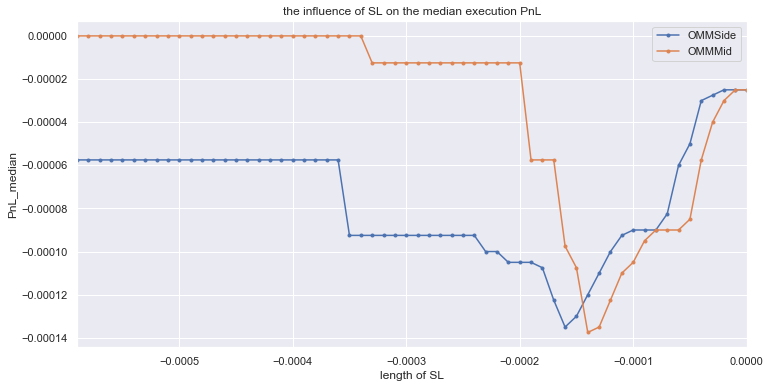

In [225]:
sl_dic = {'OMMSide':OMMSide_pnlmed, 'OMMMid':OMMMid_pnlmed}
SL_df = pd.DataFrame(data = sl_dic, index = SL_range)
PnL_sl = plt.figure(figsize=(12, 6))
ax = PnL_sl.add_subplot(111)
SL_df.plot(y=['OMMSide', 'OMMMid'], use_index=True, style='.-',ax=ax)
ax.set_xlabel('length of SL')
ax.set_ylabel('PnL_median') 
plt.title('the influence of SL on the median execution PnL')

We may conclude from the graph that although OMMMid gets a higher Pnl median most of the time, but when SL is close to 0 (from -1.5bps to 0), OMMSide actually gets a higher Pnl median. And overall, Pnl median reaches its lowest when SL is set around -1.5bps, and increases on both sides. In this sense, we may want to use a tighter or fatter SL threshold but not the one in the middle.

## 2. The influence of the length of TTE

In [ ]:
TTE_range = np.arange(5, 50, 1)
OMMSide_pnlmed1 = []
OMMMid_pnlmed1 = []

for tte in TTE_range:
    Side_med, Mid_med = OMMSide(StopLoss,tte), OMMMid(StopLoss,tte)
    OMMSide_pnlmed1.append(Side_med)
    OMMMid_pnlmed1.append(Mid_med)

Text(0.5, 1.0, 'the influence of the length of TTE on the median execution PnL')

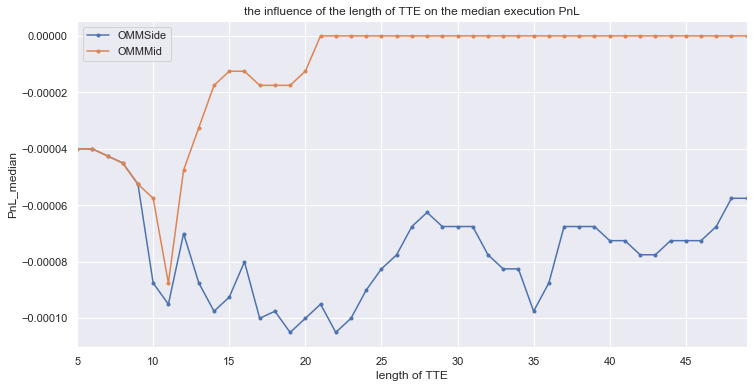

In [226]:
tte_dic = {'OMMSide':OMMSide_pnlmed1, 'OMMMid':OMMMid_pnlmed1}
TTE_df = pd.DataFrame(data = tte_dic, index = TTE_range)
Pnl_tte = plt.figure(figsize=(12, 6))
ax = Pnl_tte.add_subplot(111)
TTE_df.plot(y=['OMMSide', 'OMMMid'], use_index=True,style='.-', ax=ax)
ax.set_xlabel('length of TTE')
ax.set_ylabel('PnL_median') 
plt.title('the influence of the length of TTE on the median execution PnL')

We may conclude from the graph that OMMMid gets a higher Pnl median all the time and it reaches zero-level after TTE is set to be 20. And for OMMSide, its Pnl median is volatile and does not follow certain trend.

## 3. Choose Execution Methods

First, we may need to define out in-sample data and out-of-sample data set. Here we use first half of our Orderset to be in-sample data, and we try on different strategies with different parameters on this set, then we move on to test our strategies in out sample Orderset.

And because of the goal is to save as much as possible when execution, so the sum of execution Pnl is the stat that we consider to be the most important one. And we construct our decision strategy in this way:
First of all, just from an intuition sense, with a given lookback period (lb) before an order, we may want to check if the price is in certain state (Eg. Mean-Reversion or Break-out Trend). Let’s assume we are facing with a “Buy” order, then same process can be replicated for “Sell” order.
For a “Buy”:
1.	If the price in the lookback period is in an increasing trend, then the best way to execution is MT, since to wait in the market is more dangerous when the price enjoys an uptrend move.
2.	If the price in the lookback period is in a decreasing trend, then the best way to execution is OMMSide, since the downtrend move of the price is more likely to reach our “Side”.
3.	Or if the price in the lookback period is more likely to be mean reverting, then the best way to execution should be OMMMide, since it may save us some cost and also the condition is more likely for a fluctuating price level to reach.

Given these thoughts, we may need to define how we identify these trend or state during the lookback period, the stats we compute in this period are:
1.	Range of mid price: max – min, and call it “range”
2.	Std
3.	Difference between the earliest mid price of the period and the current mid price. And call it “diff”
When:
abs(diff) < range – N * std
we may judge it to be in the state of Mean-Reversion, so then we use OMMMide.
But when:
abs(diff) >= range – N * std
we may think the price level is in certain trend and then we look at the sign of “diff”, positive for uptrend and negative for downtrend. Then we use MT or OMMSide for a “Buy” order respectively.



In [232]:
# Frst Half order to be In-sample data, Second Half order to be  Out-of-sample data
Order_in = Order.iloc[:len(Order)//2,:]
Order_out = Order.iloc[len(Order)//2:,:]

In [267]:
OMMSide(StopLoss,TimeToExecution)
OMMMid(StopLoss,TimeToExecution)
order_in = order.iloc[:len(order)//2,:]
order_in

,Side,Time,Bid,Ask,Mid,BOSpread,MT_Pnl,OMMSide_Pnl,OMMSide_TE,OMMSide_Execution,OMMMid_Pnl,OMMMid_TE,OMMMid_Execution
0,B,2018-01-07 22:04:12,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
1,S,2018-01-07 22:04:13,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
2,B,2018-01-07 22:04:14,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
3,S,2018-01-07 22:04:15,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
4,B,2018-01-07 22:04:16,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
5,B,2018-01-07 22:04:17,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
6,B,2018-01-07 22:04:18,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
7,S,2018-01-07 22:04:19,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
8,S,2018-01-07 22:04:20,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
9,S,2018-01-07 22:04:21,1.35558,1.35615,1.355865,0.00057,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE


In [304]:
def ExecutionStrat_best(orderset,SL,TTE,lookback, N):
    order_data = orderset.copy()
    #Initialize
    Execution_Pnl = []       # execute pnl list
    Execution_TE = []        # Time to Execution
    Execution = [] # Execution type - TTE,SL,or Success
    Strat = []
    for i in range(len(order_data)):
        # Lookback period
        data_lb = data[data.index > order_data.loc[i,'Time'] - timedelta(seconds=lookback)]
        data_lb = data_lb[data_lb.index <= order_data.loc[i,'Time']]
        # Compute stats like range,std,diff
        lb_range = data_lb['Mid'].max() - data_lb['Mid'].min()
        lb_std = data_lb['Mid'].std()
        lb_diff = data_lb['Mid'][-1] - data_lb['Mid'][0]
        # Decision on strategy
        if abs(lb_diff) < lb_range - N * lb_std:
            strat = "OMMMid"
        elif lb_diff >= 0 and order_data.loc[i,'Side'] == 'B': 
            strat = "MT"
        elif lb_diff < 0 and order_data.loc[i,'Side'] == 'B': 
            strat = "OMMSide"
        elif lb_diff > 0 and order_data.loc[i,'Side'] == 'S': 
            strat = "OMMSide"
        elif lb_diff <= 0 and order_data.loc[i,'Side'] == 'S': 
            strat = "MT"     
        # After decision, compute
        data_new = data[data.index > order_data.loc[i,'Time']]
        data_new = data_new.reset_index()
        Mid = order_data.loc[i,'Mid']
        if order_data.loc[i,'Side'] == 'B':
            side_price = order_data.loc[i,'Bid']
            if strat == "MT":
                wait = 0
                execute_price = order_data.loc[i,'Ask']
            else:
                stop_loss_line = order_data.loc[i,'Ask'] - SL
                order_price = side_price if strat == "OMMSide" else Mid
                # wait in mkt
                wait = 0
                while order_price < data_new.loc[wait,'Ask'] and data_new.loc[wait, 'Ask'] < stop_loss_line and wait < TTE - 1:
                    wait = wait + 1
                if order_price >= data_new.loc[wait,'Ask']:
                    execute_price = order_price
                else:
                    execute_price = data_new.loc[wait, 'Ask'] #aggress the mkt
            # compute pnl
            Execution_Pnl.append(Mid - execute_price)
            Execution_TE.append(0 if strat == "MT" else wait + 1)
            Strat.append(strat)
            if strat == "MT":
                Execution.append('NaN')
            elif execute_price >= stop_loss_line :
                Execution.append('SL')
            elif wait == TTE - 1:
                Execution.append('TTE')
            else:
                Execution.append('Success')
                
        else : #Side =='S'
            side_price = order_data.loc[i,'Ask']
            if strat == "MT":
                wait = 0
                execute_price = order_data.loc[i,'Bid']
            else:
                stop_loss_line = order_data.loc[i,'Bid'] + SL
                order_price = side_price if strat == "OMMSide" else Mid
                # wait in mkt
                wait = 0
                while order_price > data_new.loc[wait,'Bid'] and data_new.loc[wait, 'Bid'] > stop_loss_line and wait < TTE - 1:
                    wait = wait + 1
                if order_price <= data_new.loc[wait,'Bid']:
                    execute_price = order_price
                else:
                    execute_price = data_new.loc[wait, 'Bid'] #aggress the mkt
            # compute pnl
            Execution_Pnl.append(execute_price - Mid)
            Execution_TE.append(0 if strat == "MT" else wait + 1)
            Strat.append(strat)
            if strat == "MT":
                Execution.append('NaN')
            elif execute_price <= stop_loss_line :
                Execution.append('SL')
            elif wait == TTE - 1:
                Execution.append('TTE')
            else:
                Execution.append('Success')
    # Edit in order_dataSet directly            
    order_data['Strat_Pnl'] = Execution_Pnl
    order_data['Strat_TE'] = Execution_TE
    order_data['Strat_Execution'] = Execution
    order_data['Strat'] = Strat
    return order_data['Strat_Pnl'].sum()

## In-sample grid search


Basically, this strategy contains two parameters: lookback period (lb) and Number of std (N). So we first do a grid search in the in-sample data, here shows the result, the number in the grid table is the sum of strategy execution Pnl, counts in bps:

In [377]:
Grid = pd.DataFrame(index=np.arange(0.5, 4.1, 0.5), columns= range(15, 50,5))

In [378]:
for N_ in np.arange(0.5, 4.1, 0.5):
    for lb in range(15, 50,5):
        Grid.loc[N_,lb] = ExecutionStrat_best(order_in,StopLoss,TimeToExecution,lb, N_)

In [382]:
Grid * 10000

,15,20,25,30,35,40,45
0.5,-66,-66.7,-63.8,-63.9,-63.9,-62.7,-65.6
1.0,-62.7,-63.4,-63.9,-63.9,-63.9,-63.9,-63.9
1.5,-62.7,-63.4,-63.9,-63.9,-63.9,-64.35,-64.35
2.0,-62.7,-63.4,-64.15,-64.35,-64.35,-64.35,-64.35
2.5,-62.7,-63.85,-63.95,-64.35,-64.35,-64.35,-64.35
3.0,-62.95,-63.85,-63.95,-64.35,-64.35,-64.35,-64.35
3.5,-62.95,-63.85,-63.95,-64.35,-64.35,-64.35,-64.35
4.0,-62.95,-63.85,-63.95,-64.35,-64.35,-64.35,-64.35


## In-sample performance

While the result from in-sample grid search is not that disperse, we may see that the maximum of the result lies in when lb=15 and N=1.0 to 2.5. We first compare their total Pnl with three-method-only execution strategies to see if it works during the in-sample data. Here is the result:

In [396]:
In_sample_dic = {'MT':order_in['MT_Pnl'].sum(),'OMMSide':order_in['OMMSide_Pnl'].sum(),'OMMMid':order_in['OMMMid_Pnl'].sum()}
In_sample_df = pd.DataFrame(In_sample_dic,index=['Pnl_Sum(bp)'])*10000
In_sample_df['Strat'] = ExecutionStrat_best(order_in,StopLoss,TimeToExecution,15, 2.5)*10000
In_sample_df

,MT,OMMSide,OMMMid,Strat
Pnl_Sum(bp),-51.15,-94.65,-96.75,-62.7


Text(0, 0.5, 'bps')

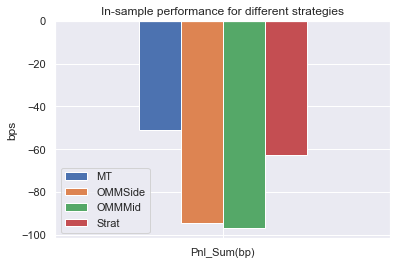

In [400]:
In_sample_df.plot(kind='bar',rot=0)
plt.title("In-sample performance for different strategies")
plt.ylabel("bps")

We may see that our strategies is better than OMM methods but worse than MT methods, but they are close to each other.
Then we go back to the grid search, however, when N falls down to 0.5, the result suffers a lot to -66bps. Since we want the parameter to be stable for the shifting, so we here chose the lb=15 and consider N equal from 1.5, 2.0, 2.5, then we test their efficacy in out-sample data.

## Out-of-sample performance

In [341]:
order_out = order.iloc[len(order)//2:,:]
order_out

,Side,Time,Bid,Ask,Mid,BOSpread,MT_Pnl,OMMSide_Pnl,OMMSide_TE,OMMSide_Execution,OMMMid_Pnl,OMMMid_TE,OMMMid_Execution
45,B,2018-01-10 10:38:29,1.35128,1.35131,1.351295,0.00003,-0.000015,0.000015,3,Success,0.000000,3,Success
46,B,2018-01-10 10:38:31,1.35132,1.35135,1.351335,0.00003,-0.000015,0.000015,1,Success,0.000000,1,Success
47,S,2018-01-10 10:38:33,1.35120,1.35123,1.351215,0.00003,-0.000015,0.000015,4,Success,0.000000,2,Success
48,S,2018-01-10 10:38:35,1.35122,1.35125,1.351235,0.00003,-0.000015,0.000015,2,Success,0.000000,2,Success
49,S,2018-01-10 10:38:37,1.35135,1.35140,1.351375,0.00005,-0.000025,0.000025,1,Success,0.000000,1,Success
50,S,2018-01-10 10:38:39,1.35141,1.35145,1.351430,0.00004,-0.000020,0.000020,9,Success,0.000000,9,Success
51,S,2018-01-10 10:38:41,1.35143,1.35150,1.351465,0.00007,-0.000035,0.000035,9,Success,0.000000,9,Success
52,S,2018-01-10 10:38:43,1.35127,1.35132,1.351295,0.00005,-0.000025,0.000025,3,Success,0.000000,1,Success
53,S,2018-01-10 10:38:45,1.35131,1.35137,1.351340,0.00006,-0.000030,0.000030,1,Success,0.000000,1,Success
54,S,2018-01-10 10:38:47,1.35142,1.35146,1.351440,0.00004,-0.000020,0.000020,3,Success,0.000000,1,Success


In [403]:
out_sample_dic = {'MT':order_out['MT_Pnl'].sum(),'OMMSide':order_out['OMMSide_Pnl'].sum(),'OMMMid':order_out['OMMMid_Pnl'].sum()}
out_sample_df = pd.DataFrame(out_sample_dic,index=['Pnl_Sum(bp)'])*10000
out_sample_df['Strat1.5'] = ExecutionStrat_best(order_out.reset_index(),StopLoss,TimeToExecution,15, 1.5)*10000
out_sample_df['Strat2.0'] = ExecutionStrat_best(order_out.reset_index(),StopLoss,TimeToExecution,15, 2.0)*10000
out_sample_df['Strat2.5'] = ExecutionStrat_best(order_out.reset_index(),StopLoss,TimeToExecution,15, 2.5)*10000
out_sample_df

,MT,OMMSide,OMMMid,Strat1.5,Strat2.0,Strat2.5
Pnl_Sum(bp),-8.9,-13.0,-15.15,-11.45,-10.1,-7.7


Text(0, 0.5, 'bps')

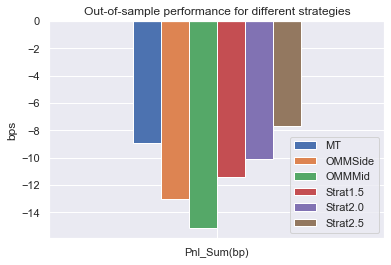

In [404]:
out_sample_df.plot(kind='bar',rot=0)
plt.title("Out-of-sample performance for different strategies")
plt.ylabel("bps")

During the out-of-sample period, we can see that our strategies are all better than OMM methods but only Strat with N = 2.5 beat the MT, improving it by around 1.2 bps, but the other two Strats, with N =2.0 and 1.5, cannot win MT method.